In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
import keras.utils as image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [3]:
def getClassIndices(set, label):#count the number of classes in a dataset
    pos_array = np.array([])
    count = 0
    for i in range(len(set)):
        if(set[i]==label).all():
            pos_array = np.append(pos_array, [i])
    pos_array = pos_array.astype(int)
    return pos_array

In [4]:
def downSampling(array, delete_count): #delete classes from a dataset to fix dataimbalance issues
    for i in range(delete_count):
        random_index = np.random.randint(0, len(array))
        array = np.delete(array, random_index)
    return array

In [5]:
#loading the data from the VOC file and performing the necessary preprocessing
df_chair = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/chair_train.txt", sep=" ", header=None, names=["id", "chair", "extra_col"])
df_dog = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/dog_train.txt", sep=" ", header=None, names=["id", "dog", "extra_col"])
df_bird = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/bird_train.txt", sep=" ", header=None, names=["id", "bird", "extra_col"])
df_cat = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/cat_train.txt", sep=" ", header=None, names=["id", "cat", "extra_col"])
df_car = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/car_train.txt", sep=" ", header=None, names=["id", "car", "extra_col"])

df_chair_val = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/chair_val.txt", sep=" ", header=None, names=["id", "chair", "extra_col"])
df_dog_val = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/dog_val.txt", sep=" ", header=None, names=["id", "dog", "extra_col"])
df_bird_val = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/bird_val.txt", sep=" ", header=None, names=["id", "bird", "extra_col"])
df_cat_val = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/cat_val.txt", sep=" ", header=None, names=["id", "cat", "extra_col"])
df_car_val = pd.read_csv("C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/ImageSets/Main/car_val.txt", sep=" ", header=None, names=["id", "car", "extra_col"])

del df_chair['extra_col']
del df_dog['extra_col']
del df_bird['extra_col']
del df_cat['extra_col']
del df_car['extra_col']

del df_chair_val['extra_col']
del df_dog_val['extra_col']
del df_bird_val['extra_col']
del df_cat_val['extra_col']
del df_car_val['extra_col']

condition_chair = (df_chair['chair'] == -1.0)
condition_dog = (df_dog['dog'] == -1.0)
condition_bird = (df_bird['bird'] == -1.0)
condition_cat = (df_cat['cat'] == -1.0)
condition_car = (df_car['car'] == -1.0)

condition_chair_val = (df_chair_val['chair'] == -1.0)
condition_dog_val = (df_dog_val['dog'] == -1.0)
condition_bird_val = (df_bird_val['bird'] == -1.0)
condition_cat_val = (df_cat_val['cat'] == -1.0)
condition_car_val = (df_car_val['car'] == -1.0)

df_chair['chair'] = np.where(condition_chair, 0, 1)
df_dog['dog'] = np.where(condition_dog, 0, 1)
df_bird['bird'] = np.where(condition_bird, 0, 1)
df_cat['cat'] = np.where(condition_cat, 0, 1)
df_car['car'] = np.where(condition_car, 0, 1)

df_chair_val['chair'] = np.where(condition_chair_val, 0, 1)
df_dog_val['dog'] = np.where(condition_dog_val, 0, 1)
df_bird_val['bird'] = np.where(condition_bird_val, 0, 1)
df_cat_val['cat'] = np.where(condition_cat_val, 0, 1)
df_car_val['car'] = np.where(condition_car_val, 0, 1)

train_df = df_chair.merge(df_dog,on='id').merge(df_bird,on='id').merge(df_cat, on='id').merge(df_car, on='id')
val_df = df_chair_val.merge(df_dog_val,on='id').merge(df_bird_val,on='id').merge(df_cat_val, on='id').merge(df_car_val, on='id')

In [6]:
train_labels = np.array(train_df.drop(['id'],axis = 1))
val_labels = np.array(val_df.drop(['id'],axis = 1))


#get count and index of df where the picture has none of the 5 classes to fix data imbalances issues
pos_empty_class_train = getClassIndices(train_labels, [0,0,0,0,0]) 
pos_empty_class_val = getClassIndices(val_labels, [0,0,0,0,0])

print(train_df.shape)
print(len(pos_empty_class_train))

print(val_df.shape)
print(len(pos_empty_class_val))

#Each of the five chosen classes are present in about 400 images, while there are about 3700 images without any of these classes
#since there is a huge data imbalance in the training as well as validation set,
#we will perform undersampling for the majority classes (images with none of the 5 classes)

#saving only 260 classes that has no images of the 5 classes in training and validation set

pos_empty_class_train = downSampling(pos_empty_class_train,260)
pos_empty_class_val = downSampling(pos_empty_class_val, 260)

#updated length
print(len(pos_empty_class_train))
print(len(pos_empty_class_val))

#removing the rows from dataframe using the pos_empty_class arrays
print("length of training set before downsamppling: ", train_df.shape[0])
train_df = train_df.drop(pos_empty_class_train)
train_df = train_df.reset_index(drop=True)
print("length of training set after downsampling: ", train_df.shape[0])

print("length of validation set before downsamppling: ", val_df.shape[0])
val_df = val_df.drop(pos_empty_class_val)
val_df = val_df.reset_index(drop=True)
print("length of  validation set after downsampling: ", val_df.shape[0])

(5717, 6)
3009
(5823, 6)
3114
2749
2854
length of training set before downsamppling:  5717
length of training set after downsampling:  2968
length of validation set before downsamppling:  5823
length of  validation set after downsampling:  2969


In [7]:
#loading the training data
train_image = []
location = 'C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/JPEGImages/'
for i in tqdm(range(train_df.shape[0])):
    img = image.load_img(location+train_df['id'][i]+'.jpg',target_size=(224,224,3))
    img = image.img_to_array(img)
    train_image.append(img)
X_train = np.array(train_image)
y_train = np.array(train_df.drop(['id'],axis = 1))

100%|█████████████████████████████████████████████████████████████████████████████| 2968/2968 [00:16<00:00, 180.68it/s]


In [8]:
#loading the validation data
val_image = []
location = 'C:/Users/zeeha/Desktop/Documents/Courses/CSCI-381/Project/Data/VOCdevkit/VOC2012/JPEGImages/'
for i in tqdm(range(val_df.shape[0])):
    img = image.load_img(location+val_df['id'][i]+'.jpg',target_size=(224,224,3))
    img = image.img_to_array(img)
    val_image.append(img)
X_val = np.array(val_image)
y_val = np.array(val_df.drop(['id'],axis = 1))

100%|██████████████████████████████████████████████████████████████████████████████| 2969/2969 [00:34<00:00, 86.37it/s]


In [9]:
#as there was no test, I created test set from the validation set
X_val, X_test = X_val[:1200], X_val[1200:]
y_val, y_test = y_val[:1200], y_val[1200:]

In [10]:
#applying the necessary preprocessing function required for the Xception model
X_train = keras.applications.xception.preprocess_input(X_train)
X_val = keras.applications.xception.preprocess_input(X_val)
X_test = keras.applications.xception.preprocess_input(X_test)

#dowloading, loading and modifying the xcpetion module pretrained on imagenet images
base_model = keras.applications.xception.Xception(weights="imagenet", include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
#as it is multilabel classification of 5 objects that are independent of each other
output = keras.layers.Dense(5, activation="sigmoid")(avg) 
model = keras.Model(inputs=base_model.input, outputs=output)

In [11]:
#freezing the lower layers as they are pretrained and will the added new layers in training
for layer in base_model.layers:
    layer.trainable=False

In [12]:
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer = optimizer)

In [13]:
history = model.fit(X_train,y_train, epochs=10, validation_data=(X_val, y_val),shuffle=True)

Epoch 1/10
93/93 [==============================] - 340s 4s/step - loss: 0.2011 - accuracy: 0.7925 - val_loss: 0.1631 - val_accuracy: 0.8200
Epoch 2/10
93/93 [==============================] - 335s 4s/step - loss: 0.1157 - accuracy: 0.8673 - val_loss: 0.1614 - val_accuracy: 0.8283
Epoch 3/10
93/93 [==============================] - 319s 3s/step - loss: 0.0990 - accuracy: 0.8770 - val_loss: 0.1584 - val_accuracy: 0.8275
Epoch 4/10
93/93 [==============================] - 318s 3s/step - loss: 0.0887 - accuracy: 0.8811 - val_loss: 0.1592 - val_accuracy: 0.8233
Epoch 5/10
93/93 [==============================] - 320s 3s/step - loss: 0.0832 - accuracy: 0.8848 - val_loss: 0.1608 - val_accuracy: 0.8217
Epoch 6/10
93/93 [==============================] - 327s 4s/step - loss: 0.0793 - accuracy: 0.8878 - val_loss: 0.1631 - val_accuracy: 0.8225
Epoch 7/10
93/93 [==============================] - 318s 3s/step - loss: 0.0765 - accuracy: 0.8892 - val_loss: 0.1611 - val_accuracy: 0.8217
Epoch 8/10
93

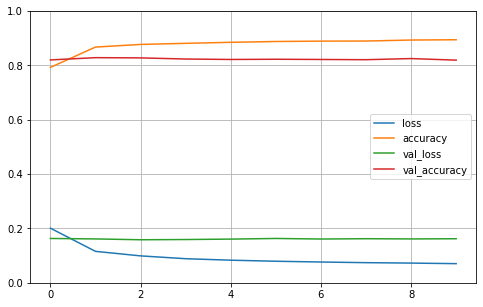

<Figure size 432x288 with 0 Axes>

In [14]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()
plt.savefig("xception_prefreeze.pdf", format="pdf")

The training data consisted of 2968 images and the validation data consisted of 2969 images. Since
173 the validation data was almost equal to the training data, I divided the validation data into validation
174 and test data. Having a test data is crucial as our model has never seen the data and represents the
175 real test data, giving us an accurate measure of the generalization error. The validation consisted of
176 1200 images and the test data consisted of the remaining 1769 images. It is crucial to have validation
177 so we can make sure that our model is not overfitting. Here is graphical representation of training
178 accuracy score, accuracy loss, validation accuracy score and validation loss.

As we can see from the graph, the trianing accuracy starts almost at 80 percent in the first epoch
182 and gradually goes beyond 90 percent at the end of training. The validation accuracy denotes how
183 the model performs on a data that it has not trained on. The validation accuracy remains around 83
184 percent which is acceptably close to the training accuracy, signifying our modified Xception model is
185 performingly well and not overfitting the data. We also shuffle the training data after every epoch so
186 the model does not see the training data in the same order at every epoch. This ensures our model is
187 immune to bias in the data.
188
189 We see a similar trend when it comes to the training and validation loss. The training loss signifies
190 the amount of error of the model in the training set while the validation loss signifies the error of the
191 model on the validation set. As both the loss are close to each other, we determine our architecture is
192 not overfitting.

In [ ]:
#since all the layers are now trained, unfreezing the lower layers to slightly tune them to our specific problem
for layer in base_model.layers:
    layer.trainable=True

In [20]:
#using a low learning rate so not to damage the pretrained lower layers
optimizer = keras.optimizers.legacy.SGD(learning_rate = 0.01, momentum=0.9, decay=0.001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer = optimizer)

In [21]:
history = model.fit(X_train,y_train, epochs=3, validation_data=(X_val, y_val), shuffle = False)

Epoch 1/3
93/93 [==============================] - 1271s 13s/step - loss: 0.1361 - accuracy: 0.8491 - val_loss: 0.1693 - val_accuracy: 0.8192
Epoch 2/3
93/93 [==============================] - 1213s 13s/step - loss: 0.0573 - accuracy: 0.9023 - val_loss: 0.1565 - val_accuracy: 0.8317
Epoch 3/3
93/93 [==============================] - 1235s 13s/step - loss: 0.0335 - accuracy: 0.9097 - val_loss: 0.1510 - val_accuracy: 0.8350


In [23]:
predictions = (model.predict(X_test) > 0.5).astype("int32")

56/56 [==============================] - 105s 2s/step


In [24]:
for i in range(len(y_val)):
    print(predictions[i], "actual label", y_test[i])

[0 0 1 0 0] actual label [0 0 1 0 0]
[0 0 0 0 1] actual label [0 0 0 0 1]
[0 0 0 1 0] actual label [0 0 0 1 0]
[0 1 0 0 0] actual label [0 1 0 0 0]
[0 1 0 0 0] actual label [0 1 0 0 0]
[1 0 0 0 0] actual label [1 0 0 0 0]
[1 0 0 0 0] actual label [1 0 0 0 0]
[0 0 1 0 0] actual label [0 0 1 0 0]
[0 0 0 0 0] actual label [0 0 0 0 1]
[1 0 0 0 0] actual label [0 0 0 0 0]
[0 0 1 0 0] actual label [0 0 1 0 0]
[0 0 0 1 0] actual label [0 0 0 1 0]
[0 1 0 0 0] actual label [0 1 0 0 0]
[1 0 0 0 0] actual label [1 0 0 0 0]
[0 0 0 1 0] actual label [0 0 0 1 0]
[0 0 1 0 0] actual label [0 0 1 0 0]
[1 0 0 0 0] actual label [1 0 0 0 0]
[0 0 0 1 0] actual label [0 0 0 1 0]
[1 0 0 0 0] actual label [0 0 0 0 0]
[0 0 0 1 0] actual label [0 0 0 1 0]
[1 0 0 0 0] actual label [1 0 0 0 0]
[1 0 0 0 0] actual label [1 0 0 0 0]
[1 0 0 0 0] actual label [1 0 0 0 0]
[1 0 0 0 0] actual label [1 0 0 0 0]
[1 0 0 0 0] actual label [1 0 0 0 0]
[0 1 0 0 0] actual label [0 1 0 0 0]
[0 1 0 0 0] actual label [0 1 0 0 0]
[

In [22]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.12743699550628662
Test accuracy: 0.8648954033851624
